In [1]:
import datetime
import time as time_module
import sys
import os 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'
path_save_pickled = '../../data'
rerun = True

INFO: This code is not longer developed, use our new module instead: github.com/Priesemann-Group/covid19_inference


In [2]:

confirmed_cases = cov19.get_jhu_confirmed_cases()

country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
# date_data_end   = cov19.get_last_date(confirmed_cases)
date_data_end = datetime.datetime(2020,4,21)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]
fact_larger = 4
change_points_larger = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3*fact_larger,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3*fact_larger),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1*fact_larger,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3*fact_larger),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1*fact_larger,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3*fact_larger)]
if rerun:

    traces = []
    models = []
    
    model_delay = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                        change_points_list = change_points,
                                        date_begin_simulation = date_begin_sim,
                                        num_days_sim = num_days_sim,
                                        diff_data_sim = diff_data_sim,
                                        N = 83e6,
                                        priors_dict= dict(pr_sigma_delay = 0.2*fact_larger),
                                        weekends_modulated=True,
                                        weekend_modulation_type = 'abs_sine')
    models.append(model_delay)
    traces.append(pm.sample(model=model_delay, init='advi+adapt_diag', draws=4000, tune=1000))
    
    model_days = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                    change_points_list = change_points_larger,
                                    date_begin_simulation = date_begin_sim,
                                    num_days_sim = num_days_sim,
                                    diff_data_sim = diff_data_sim,
                                    N = 83e6,
                                    priors_dict = None,
                                    weekends_modulated=True,
                                    weekend_modulation_type = 'abs_sine')
    
    models.append(model_days)

    traces.append(pm.sample(model=model_days, init='advi+adapt_diag', draws=4000, tune=1000))



    pickle.dump([models, traces], open(path_save_pickled + 'SIR_with_sine_with_larger_prior.pickled', 'wb'))

else: 
    models, traces = pickle.load(open(path_save_pickled + 'SIR_with_sine_with_larger_prior.pickled', 'rb'))

    

Cases yesterday (2020-04-21T00:00:00): 148291 and day before yesterday: 147065
pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_beta_sigma_obs was set to default value 10
week_end_days was set to default value (6, 7)
pr_mean_weekend_factor was set to default value 0.7
pr_sigma_weekend_factor was set to default value 0.17
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3
pr_sigma_transient_len of change point 0 was set to default value 0.3
pr_sigma_transient_len of change point 1 was set to default value 0.3
pr_sigma_transient_len of change point 2 was set to default value 0.3


INFO (theano.gof.compilelock): Waiting for existing lock by process '7541' (I am process '7603')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '7541' (I am process '7603')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 453.34:  12%|█▏        | 23876/200000 [00:43<05:20, 549.94it/s]
Convergence achieved at 23900
Interrupted at 23,899 [11%]: Average Loss = 558.68
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset_modulation_rad, weekend_factor, sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0,

pr_beta_I_begin was set to default value 100
pr_median_lambda_0 was set to default value 0.4
pr_sigma_lambda_0 was set to default value 0.5
pr_median_mu was set to default value 0.125
pr_sigma_mu was set to default value 0.2
pr_median_delay was set to default value 8
pr_sigma_delay was set to default value 0.2
pr_beta_sigma_obs was set to default value 10
week_end_days was set to default value (6, 7)
pr_mean_weekend_factor was set to default value 0.7
pr_sigma_weekend_factor was set to default value 0.17
pr_median_transient_len of change point 0 was set to default value 3
pr_median_transient_len of change point 1 was set to default value 3
pr_median_transient_len of change point 2 was set to default value 3


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 476.34:  10%|▉         | 19158/200000 [00:39<06:11, 487.03it/s]
Convergence achieved at 19200
Interrupted at 19,199 [9%]: Average Loss = 593.16
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [offset_modulation_rad, weekend_factor, sigma_obs, delay, mu, transient_len_2, transient_len_1, transient_len_0, transient_begin_2, transient_begin_1, transient_begin_0, lambda_3, lambda_2, lambda_1, lambda_0, I_begin]
Sampling 4 chains, 12 divergences: 100%|██████████| 20000/20000 [1:08:39<00:00,  4.85draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [5]:
exec(open('figures_revised.py').read())

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2037: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2037: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


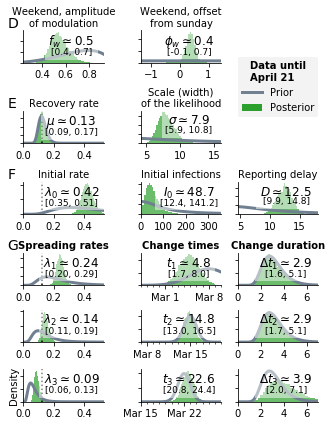

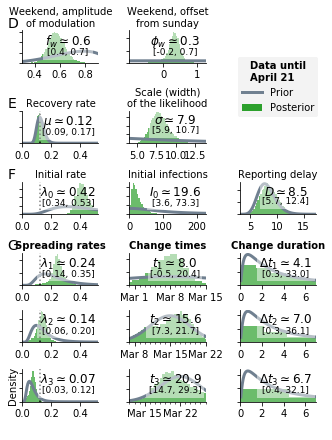

In [8]:
create_figure_distributions(models[0], traces[0],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:green',
                              num_changepoints=3, xlim_tbegin=7, save_to = path_to_save +'Fig_larger_prior_delay_dist')
create_figure_distributions(models[1], traces[1],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:green',
                              num_changepoints=3, xlim_tbegin=8, save_to = path_to_save +'Fig_larger_prior_day_dist')


(<Figure size 288x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f571a3b5a10>,
       dtype=object))

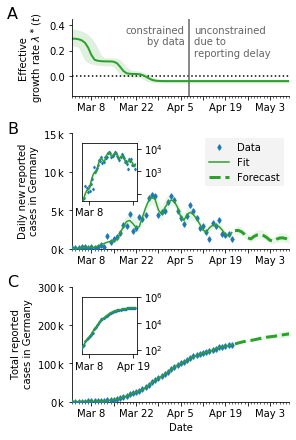

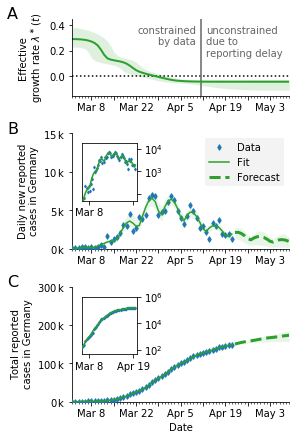

In [9]:
create_figure_timeseries(traces[0], 'tab:green',
                       plot_red_axis=True, save_to = path_to_save +'Fig_larger_prior_delay_cases')
create_figure_timeseries(traces[1], 'tab:green',
                       plot_red_axis=True, save_to = path_to_save +'Fig_larger_prior_day_cases')
#create_figure_timeseries(traces[3], 'tab:green',
#                       plot_red_axis=True, save_to=path_to_save + 'Fig_S3')

In [10]:
print('\nlarge prior delay\n')
print(pm.loo(traces[0], models[0]))

print('\nlarge prior days\n')
print(pm.loo(traces[1], models[1]))



large prior delay

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   786.41    17.21
p_loo     13.85        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   96.1%
 (0.5, 0.7]   (ok)          2    3.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


large prior days

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   785.74    16.81
p_loo     14.07        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       50   98.0%
 (0.5, 0.7]   (ok)          1    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

